### Simple code to simulate mutation survival probability $u$

The below implements a simple finite difference iteration algorithm to simulate the equation

$$ \partial_t u= D u'' - v u' + a \Theta(x) u - \text{coff  } u^2 - \text{wind  } u'^2 $$

the iteration loop would likely run much faster in C, but even this code converges quite rapidly. One has to know, however, how to correctly set the key parameters. More on this below.

We'll first keep a finite value of coff, and later switch to coff=0.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import importlib

import simulate
importlib.reload(simulate)
from simulate import *

v = 0.31622776601683794
Natural length scale L_N = 10.0
L/L_N = 30.0
L_N/dx = 50.0


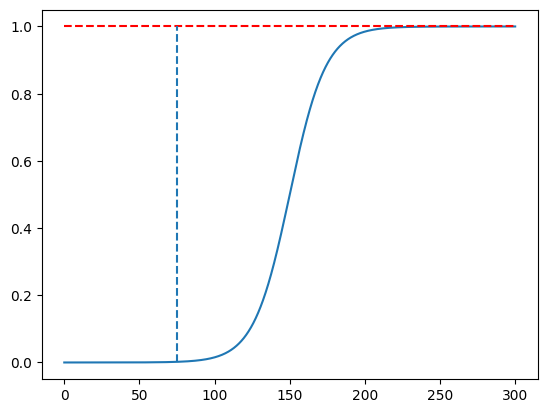

In [5]:
# Constants
D = 1.0  # Diffusion coefficient
a = 0.1  # growth rate 
coff = 0.1 #  strength of u^2 non-linearity 
wind = 0.0 #  strength of u'^2 non-linearity 
vf = 2 * (D*a)**0.5
v = .5* vf # wind speed
print(f"v = {v}")

# Lattice
L_N = np.sqrt(D)/a
print("Natural length scale L_N =", L_N)
L = 300.0  # Length of the domain
dx = 0.2# Spatial step size

N = int(L / dx) + 1
print(f"L/L_N = {L/L_N}")
print(f"L_N/dx = {L_N/dx}")

if coff != 0: asym = a/coff
else: asym=100
u_0 = sigmoid_initial(L, N, asym)#a/coff)
plt.plot(np.linspace(0, L, N), u_0)
plt.hlines(asym, 0, L, colors='r', linestyles='dashed')
plt.vlines(L/4, 0, asym, linestyles='dashed')

In [9]:
importlib.reload(simulate)
from simulate import *

load=True
# Time
M = 200000 # Number of time steps
dt = 0.01  # Time step size
print(f"Max time T/T_N: {M*dt/(1/a)}")
save_skip = 10000 # for memory
coff=0.1
#winds=[0.0, 1.0, 10.0]
#Vs = [0.995, 0.995, 0.995]#0.99
#params = [v, wind, coff]
#Vs = [0.99]
#Vs = [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.93, 
#Vs = [0.94, 0.95, 0.96, 
#Vs = [0.995]
#winds = [0.0, 1.0, 5.0, 10.0, 50.0]
#Vs = np.ones_like(winds)*0.99
#winds=np.ones_like(Vs)*100.0

winds = [0.0]#0.0, 1.0, 5.0, 10.0, 50.0]
Vs = np.ones_like(winds)*0.5
bc = 'mixed'
#u_0 = sigmoid_initial(L, N, asym)
for i, V in enumerate(Vs):
    if load:  # Try to load the saved solution
        wind = winds[i]
        filename = "u_sols/" + get_filename(D, V, a, wind, coff, N, dx, bc=bc)
        if os.path.exists(filename):
            print(f"File '{filename}' found. Using pre-simulated u(x) as initial condition.")
            u_0 = np.load(filename)[-1]
        else:
            print(f"File '{filename}' not found. Using initial conditions instead.")
            load = True
            if i == 0: u_0 = sigmoid_initial(L, N, asym)
    else:  # If load is True, use initial conditions
        u_0 = sigmoid_initial(L, N, asym, bc)
        #u_0 -= u_0[0]
    u_sim = u_simulation(u_0, bc, D, V, a, wind, coff, N, dx)
    u_sim.simulate(M, dt, debug=False, save_skip=save_skip)
    u = u_sim.u_list
    print(u.shape)
    if i > 0 and not load: u_0 = u[-1]

Max time T/T_N: 200.0
File 'u_sols/solution_D_1_v_0.5_a_0.1_wind_0_coff_0.1_N_1501_dx_0.2.npy' found. Using pre-simulated u(x) as initial condition.


100%|██████████| 200000/200000 [00:07<00:00, 28455.62it/s]

Simulation complete for v = 0.5*v_f
Final relative number difference: 0.0
Solution saved to u_sols/solution_D_1_v_0.5_a_0.1_wind_0_coff_0.1_N_1501_dx_0.2.npy
(22, 1501)


(22, 1501)


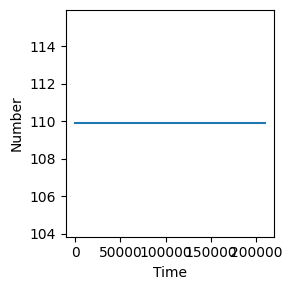

In [10]:
u=u_sim.u_list
print(u.shape)
# Create a figure and two subplots
fig, ax1 = plt.subplots(1, 1, figsize=(3, 3))  # 1 row, 2 columns

# First plot: Total sum of u over time
ax1.plot(np.arange(len(u)) * save_skip, np.sum(u * dx, axis=1))
ax1.set_xlabel('Time')
ax1.set_ylabel('Number')
plt.tight_layout()
# Show the plots
plt.show()

#print(u[-1][-10:])

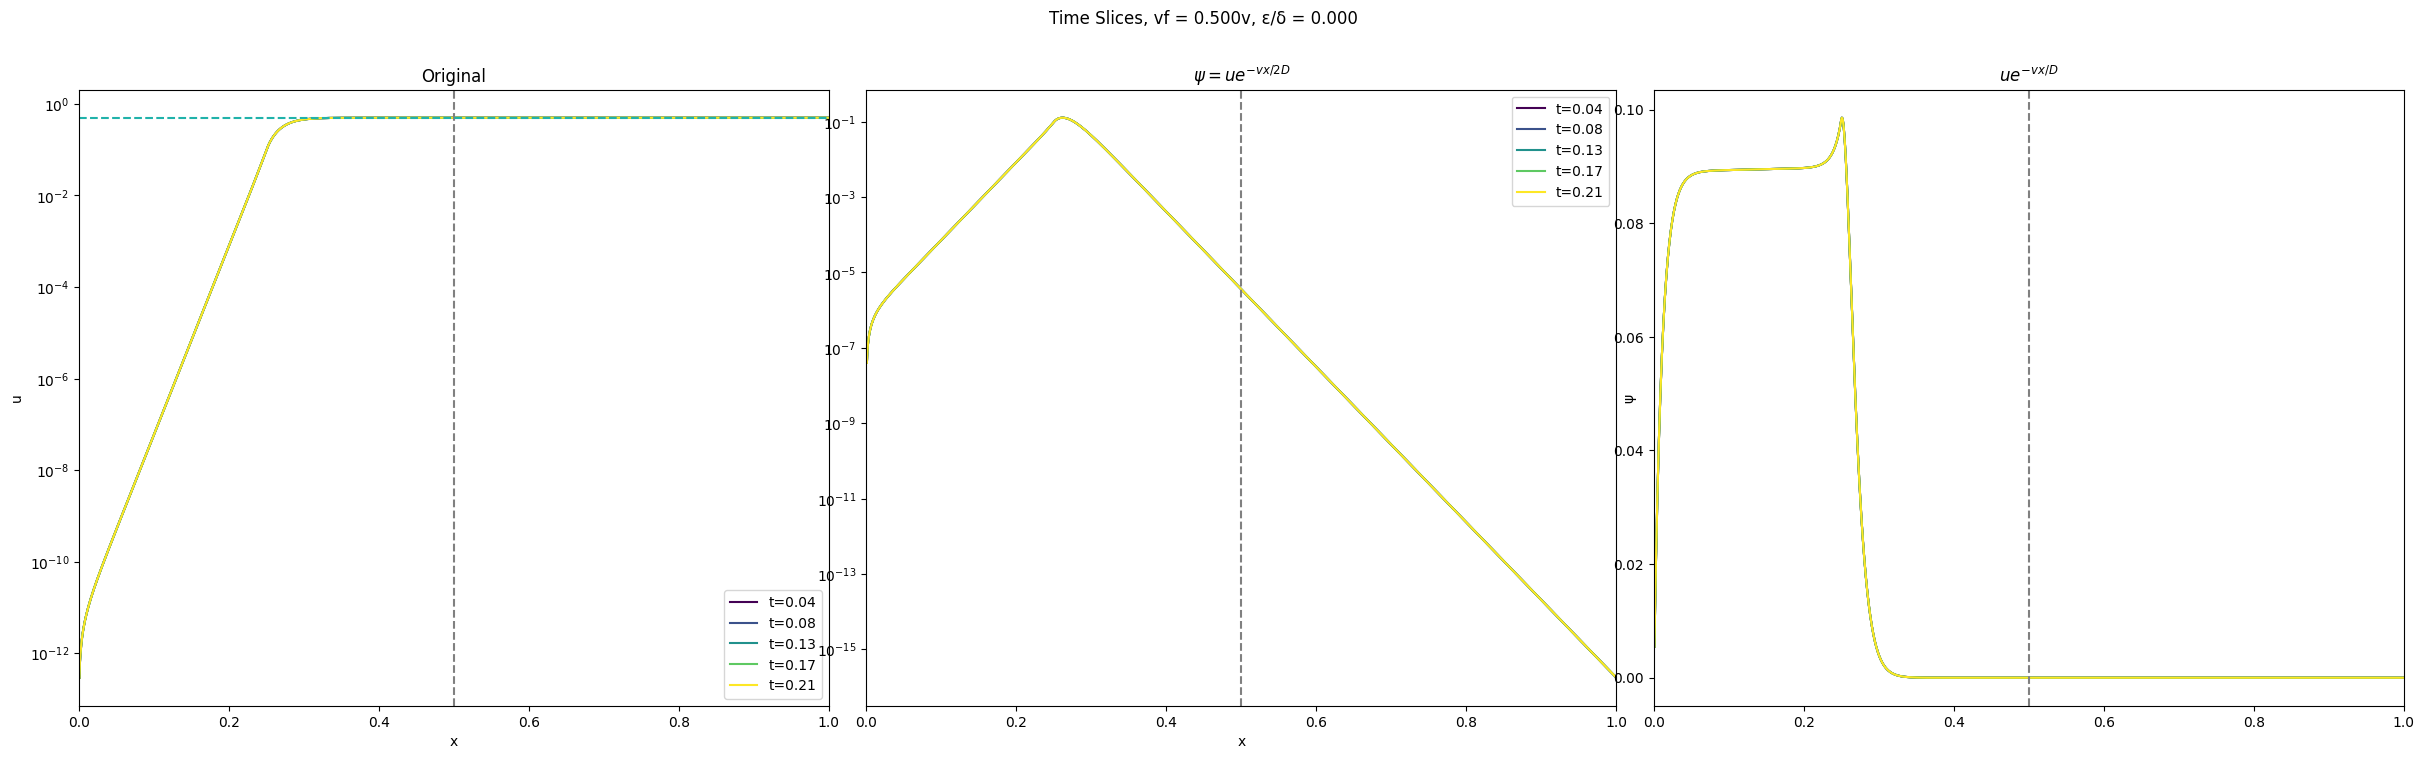

In [11]:
importlib.reload(simulate)
from simulate import *
eps_over_delta = 0#wind/coff
plot_time_slices(u, L, dt, N, M, D, Vs[-1], a, coff, eps_over_delta, save_skip=1, psi=True, 
                 log_scale=True, xlim=(0.0,1.0))#, ylim=(1e-25,1.1*u[-1][-1]))#, psi_ylim=(1e-30,1e-11))

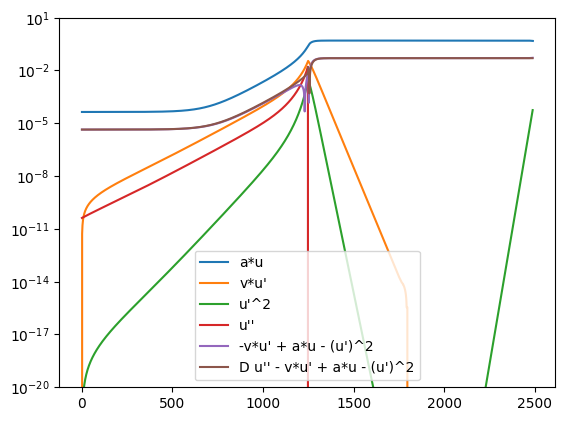

In [48]:
us = u[-1][:-10]
plt.plot(us, label="a*u")
plt.plot(v*(us[1:]-us[:-1])/dx, label="v*u'")
plt.plot((us[1:]-us[:-1])**2/dx**2, label="u'^2")
plt.plot((us[2:] - 2 * us[1:-1] + us[:-2]) / dx**2, label="u''")

plt.plot(np.abs(-v*(us[1:]-us[:-1])/dx + a* us[1:] - wind * (us[1:]-us[:-1])**2/dx**2), label="-v*u' + a*u - (u')^2")
plt.plot(np.abs((us[2:] - 2 * us[1:-1] + us[:-2]) / dx**2 -v*(us[2:]-us[1:-1])/dx + a * us[2:] - wind * (us[2:]-us[1:-1])**2/dx**2), label="D u'' - v*u' + a*u - (u')^2")

plt.legend()
plt.ylim((1e-20,1e1))
plt.yscale("log")